In [68]:
import cv2
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import os               
from random import shuffle
from tqdm import tqdm 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import random
import seaborn as sns
import time
#models
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
#scores
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import glob

## *About are data set:*
#### We are working with data that recorded hands of humans. We are comparing 2 of those people in 3 different states:
<span style="color:cyan">Alone- </span> One of the humans hands move freely.
<br> <span style="color:pink">Sync- </span> Both of the humans hands move simultaneously trying to synchronize.
<br> <span style="color:gold">Spontan - </span> Both of the humans hands move freely and randomly.
<br>
Our Goal is to classify according to their hand movments at what state, of the 3 we stated, the hands are.
    

## Data assembling and Visualization

As written in the assaignment we will take out the first 7 seconds of each instance using iloc when building our data frame.We will then build the data sets of each of the three states -  alone sync and Spontan. The data is uneven therefore we will need to even out the hands, we will do so by deleting any of the #hands column that doesn't have 2 hands. After we have cleaned out and evened the data for the three states we will will combine the left and right to the same column.<br> Then we combine the data of Right_hand and Alone . <br>Finally We combine those datasets and achieve our fully ready and prepared dataset. 
<br> Note: Alot of this code was taken from A notebook on github of A student 2 years ago and I modified it.

In [69]:
warnings.filterwarnings("ignore")

def dfbuilder(files):
    final=pd.DataFrame(columns=['Time_x', 'Experiment_x', ' Hand Type_x', ' # hands_x', ' Position X_x',
       ' Position Y_x', ' Position Z_x', ' Velocity X_x', ' Velocity Y_x',
       ' Velocity Z_x', ' Pitch_x', ' Roll_x', ' Yaw_x', ' Wrist Pos X_x',
       ' Wrist Pos Y_x', ' Wrist Pos Z_x', ' Elbow pos X_x', ' Elbow Pos Y_x',
       ' Elbow Pos Z_x', ' Grab Strenth_x', ' Grab Angle_x',' Pinch Strength_x', 
       'Time_y', 'Experiment_y',
       ' Hand Type_y', ' # hands_y', ' Position X_y', ' Position Y_y',
       ' Position Z_y', ' Velocity X_y', ' Velocity Y_y', ' Velocity Z_y',
       ' Pitch_y', ' Roll_y', ' Yaw_y', ' Wrist Pos X_y', ' Wrist Pos Y_y',
       ' Wrist Pos Z_y', ' Elbow pos X_y', ' Elbow Pos Y_y', ' Elbow Pos Z_y',
       ' Grab Strenth_y', ' Grab Angle_y', ' Pinch Strength_y'])
    for file in files:
        temp=pd.read_csv(file)
        temp=temp.iloc[700:]
        temp[" Hand Type"]=Series([1 if i=="right" else 2 for i in temp[" Hand Type"]])
        if str.__contains__(file,"Alone"):  
            temp.insert(loc=1, column='Experiment', value="1")
            temp=temp.drop(' Frame ID',axis=1)
            Handright=pd.read_csv('HandRight.csv')
            Handright[" Hand Type"]=Series([1 if i=="right" else 2 for i in Handright[" Hand Type"]])
            Handright.insert(loc=1, column='Experiment', value="1")
            Handright = Handright.iloc[:len(temp)-1]
            Handright = Handright.reset_index(drop=True)
            Handright=Handright.drop(' Frame ID',axis=1)
            temp = temp.reset_index(drop=True)
            temp = pd.merge(temp, Handright, left_index=True, right_index=True)
        else:
            if str.__contains__(file,"Sync"):
                temp.insert(loc=1, column='Experiment', value="2")
            if str.__contains__(file,"Spontan"):
                temp.insert(loc=1, column='Experiment', value="3") 
            dfright=temp[temp[" Hand Type"]==1]
            dfleft=temp[temp[" Hand Type"]==2]
            dfright.set_index(' Frame ID',inplace=True)
            dfleft.set_index(' Frame ID',inplace=True)
            temp=pd.merge(dfleft, dfright, how='left',on=' Frame ID') 
        final=pd.concat([final,temp])
        
    final=final.drop(["Experiment_y"],axis=1) 
    final=final.dropna()
    final[final.index%20==2]
    final.sort_index(inplace=True)
    return final

In [70]:
test= dfbuilder(glob.glob('Validation/**/*.csv', recursive=True))
df= dfbuilder(glob.glob('Training/**/*.csv', recursive=True))
df.head()

,Time_x,Experiment_x,Hand Type_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,507.6639,1,2.0,1,-54.173900,404.6508,102.53100,-46.375400,-141.2727,-30.21356,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,300.3558,1,2.0,1,0.483595,263.7752,48.87287,-73.144260,247.4470,-70.95473,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,465.7203,1,2.0,1,-20.202960,196.3637,27.31069,-1.707349,180.4482,39.11984,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,399.2171,1,2.0,1,-168.143600,213.8697,-117.56460,-78.960600,149.8754,-29.06095,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,573.0565,1,2.0,1,-90.512630,170.7388,-30.87672,-449.169100,182.5208,237.29880,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0


Yay! we have a data set. Now we can use some visulization tools.

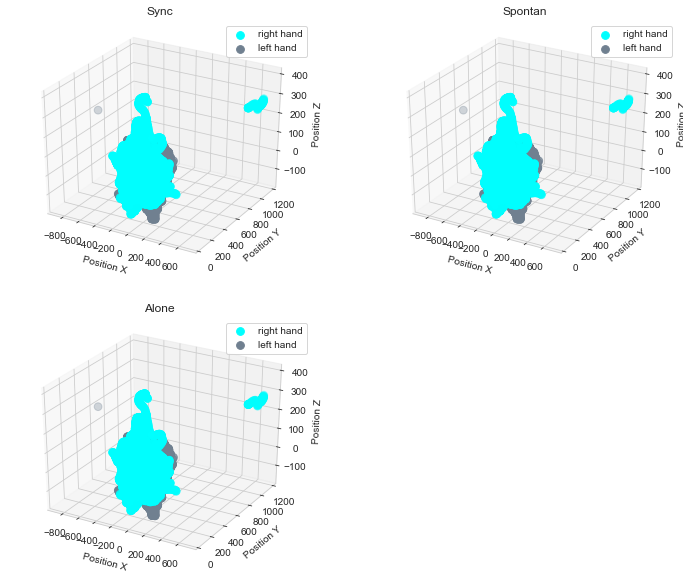

In [71]:
df1 = df.drop('Experiment_x',axis=1)
fig = plt.figure(figsize=(12, 10))
Type = ['Sync', 'Spontan','Alone']
count = 1
for t in Type:
    ax = fig.add_subplot(2, 2, count, projection='3d')
    count+=1
    ax.title.set_text(t)
    plt.gca().legend(('left','right'))
    ax.scatter(df1[' Position X_x'], df1[' Position Y_x'], df1[' Position Z_x' ], color='cyan',s=60, label='right hand')
    ax.scatter(df1[' Position X_y'], df1[' Position Y_y'], df1[' Position Z_y'],color='slategrey',s=60, label='left hand')
    plt.legend()
    ax.set_xlabel('Position X')
    ax.set_ylabel('Position Y')
    ax.set_zlabel('Position Z')

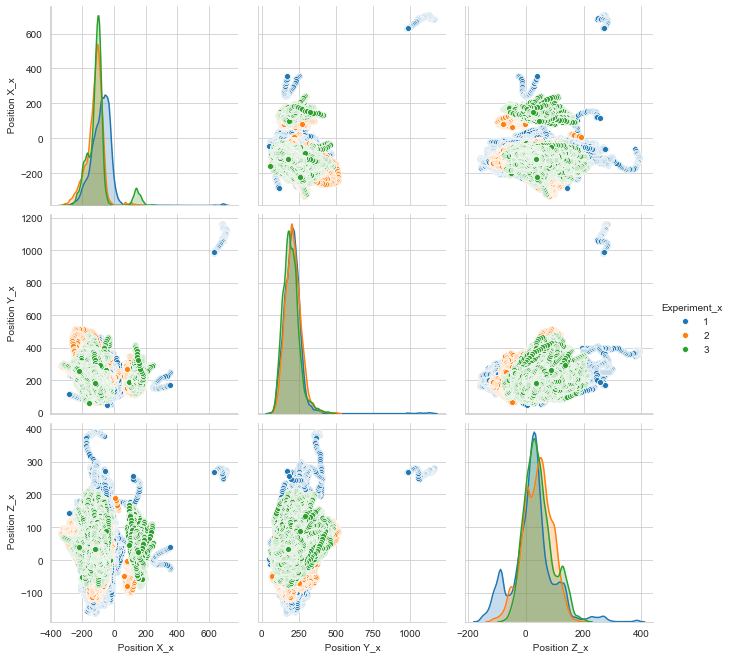

In [72]:
sns.set_style("whitegrid");
sns.pairplot(df,vars = [' Position X_x',' Position Y_x',' Position Z_x'], hue="Experiment_x", size=3)
plt.show()

Lets create A correlation map to try and understand which columns mite be unnecessary 

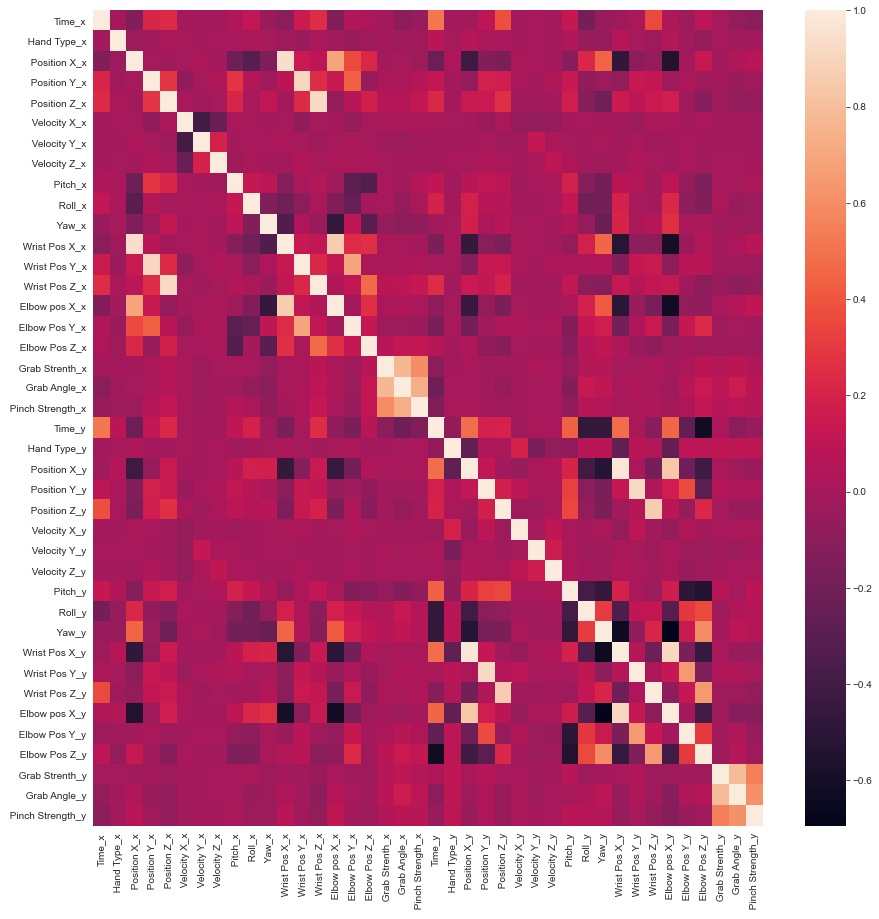

In [73]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr())

## Data split and Preprocessing

After visualizing and understanding are data we will clean it. Lets check if there is any null values and then drop the columns which we understand are needed to drop

In [74]:
df.shape

(88369, 43)

In [75]:
df.isnull().sum()

Time_x               0
Experiment_x         0
 Hand Type_x         0
 # hands_x           0
 Position X_x        0
 Position Y_x        0
 Position Z_x        0
 Velocity X_x        0
 Velocity Y_x        0
 Velocity Z_x        0
 Pitch_x             0
 Roll_x              0
 Yaw_x               0
 Wrist Pos X_x       0
 Wrist Pos Y_x       0
 Wrist Pos Z_x       0
 Elbow pos X_x       0
 Elbow Pos Y_x       0
 Elbow Pos Z_x       0
 Grab Strenth_x      0
 Grab Angle_x        0
 Pinch Strength_x    0
Time_y               0
 Hand Type_y         0
 # hands_y           0
 Position X_y        0
 Position Y_y        0
 Position Z_y        0
 Velocity X_y        0
 Velocity Y_y        0
 Velocity Z_y        0
 Pitch_y             0
 Roll_y              0
 Yaw_y               0
 Wrist Pos X_y       0
 Wrist Pos Y_y       0
 Wrist Pos Z_y       0
 Elbow pos X_y       0
 Elbow Pos Y_y       0
 Elbow Pos Z_y       0
 Grab Strenth_y      0
 Grab Angle_y        0
 Pinch Strength_y    0
dtype: int6

We will drop the following values. The reason for which we are doing this is because we are trying to build A model that will  determine in which stage the hands are at that given point.And build the best model that will classify just that.<br> Time, hand type and hands as we understood from the data will not help with our goal and are not helpful parameters . The reason being is that they don't deal with understanding the position of the hand at that given moment. Thus we will drop those values and achieve A better more accurate model.

In [76]:
df.drop(['Time_x',' Hand Type_x',' # hands_x','Time_y', ' Hand Type_y', ' # hands_y'],axis = 1, inplace = True)
test.drop(['Time_x',' Hand Type_x',' # hands_x','Time_y', ' Hand Type_y', ' # hands_y'],axis = 1, inplace = True)

In [77]:
X= df.drop(['Experiment_x'],axis=1)
y=df['Experiment_x']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=120)
print(" Shape of x_train = ", X_train.shape)
print(" Shape of x_test = ", X_test.shape)
print(" Shape of y_train = ", y_train.shape)
print(" Shape of y_test = ", y_test.shape)

 Shape of x_train =  (61858, 36)
 Shape of x_test =  (26511, 36)
 Shape of y_train =  (61858,)
 Shape of y_test =  (26511,)


In [79]:
scale_pipeline = Pipeline([
 ("std_scaler", StandardScaler()),
 ("pca", PCA(n_components=0.99, random_state=0,svd_solver='full')),
])
x_train_reduced = scale_pipeline.fit_transform(X_train)
x_test_reduced = scale_pipeline.transform(X_test)

## It's time to start training models!
<br>
<br>note: We will print out classification reports only for our strongest models.

### *Knn Classifier*

In [80]:
knn_clf =  KNeighborsClassifier(n_neighbors=10,weights='distance',n_jobs=-1)

knn_clf.fit(x_train_reduced,y_train)
knn_clf.score(x_test_reduced,y_test)

0.9966806231375656

In [81]:
from sklearn.model_selection import cross_val_score

knn_scores = cross_val_score(knn_clf, x_train_reduced, y_train, cv=5)
knn_scores.mean()

0.9962009803441154

We can see that we scored just about the same with cross validation meaning are model is a great model and is not overfitting.
<br>

We will run a type of gridsearch inorder to find the optimal number of neighbors.

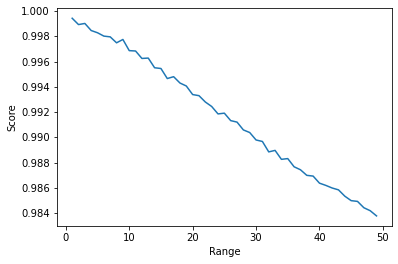

In [25]:
score_array = []
for each in range(1,50):
    knn_loop = KNeighborsClassifier(n_neighbors = each)
    knn_loop.fit(x_train_reduced,y_train)
    score_array.append(knn_loop.score(x_test_reduced,y_test))
    
plt.plot(range(1,50),score_array)
plt.xlabel("Range")
plt.ylabel("Score")
plt.show()

### *Logistic Regression*

In [82]:
log_reg = LogisticRegression(random_state=42,solver='liblinear',n_jobs=-1)
log_reg.fit(x_train_reduced, y_train)
log_reg.score(x_test_reduced, y_test)

0.8426313605673117

### *Gaussian  Classifier*

In [83]:
gnb_clf =  GaussianNB()

gnb_clf.fit(x_train_reduced,y_train)
gnb_clf.score(x_test_reduced,y_test)

0.7727358454980952

# Ensemble methods

### *Random Forest Classifier*

In [84]:
model_rf = RandomForestClassifier(criterion ='entropy' ,max_features='sqrt' , min_samples_leaf=4, min_samples_split=3,n_estimators=250 , n_jobs = -1, random_state =42, 
                                  max_depth=50)
model_rf.fit(x_train_reduced, y_train)
prediction_test = model_rf.predict(x_test_reduced)
(metrics.accuracy_score(y_test, prediction_test))

0.9916261174606767

###  *AdaBoost*

In [85]:
ada_clf = AdaBoostClassifier(
 DecisionTreeClassifier(max_depth=3), n_estimators=150,
 algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(x_train_reduced, y_train)
prediction_test = ada_clf.predict(x_test_reduced)
(metrics.accuracy_score(y_test, prediction_test))

0.8265625589377994

### *GradientBoostingClassifier*

In [86]:
grd_clf = GradientBoostingClassifier(max_depth=4, n_estimators=20, learning_rate=0.15, subsample=0.7)
grd_clf.fit(x_train_reduced, y_train)
prediction_test = grd_clf.predict(x_test_reduced)
(metrics.accuracy_score(y_test, prediction_test))

0.9019275017917091

###  *XGBoost*

In [87]:
xg_boost = XGBClassifier(n_estimators = 150, n_jobs = -1)
xg_boost.fit(x_train_reduced,y_train)
xg_boost.score(x_test_reduced, y_test)

[18:03:56] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9953604164309154

In [67]:
param_grid=[{'max_depth':[5,10],
           'n_estimators':[50,100,150],
           'learning_rate':[0.05,0.1],
           'colsample_bytree':[0.8,0.95]}]
random_cv = RandomizedSearchCV(XGBClassifier(), param_distributions=param_grid, n_jobs=-1, cv=5)
random_cv.fit(x_train_reduced, y_train)

[07:12:15] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                          

In [88]:
report = classification_report(y_test, xg_boost.predict(x_test_reduced))
print(report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      8046
           2       0.99      0.99      0.99      9192
           3       0.99      0.99      0.99      9273

    accuracy                           1.00     26511
   macro avg       1.00      1.00      1.00     26511
weighted avg       1.00      1.00      1.00     26511



### *Voting Classifier*

We saw that are best models are- knn , random forest and xgboost. Lets combine them into a voting classifier( we will run A strong one and A week one and see if we can achieve an even greater result)

<b> Soft voting 

In [37]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
voting_clf = VotingClassifier(
 estimators=[('knn', knn_clf), ('rf', model_rf), ('xgb', xg_boost)],
 voting='soft')
voting_clf.fit(x_train_reduced, y_train)
for clf in (knn_clf, model_rf, xg_boost,voting_clf):
     clf.fit(x_train_reduced, y_train)
     y_pred = clf.predict(x_test_reduced)
     print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

[19:24:07] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
KNeighborsClassifier 0.9988306740598242
RandomForestClassifier 0.9916261174606767
[19:25:14] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier 0.9493040624646373
[19:26:26] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
VotingClassifier 0.9975859077364113


In [38]:
report = classification_report(y_test, voting_clf.predict(x_test_reduced))
print(report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      8046
           2       1.00      1.00      1.00      9192
           3       1.00      1.00      1.00      9273

    accuracy                           1.00     26511
   macro avg       1.00      1.00      1.00     26511
weighted avg       1.00      1.00      1.00     26511



<b> Hard voting

In [39]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
voting_clf_h = VotingClassifier(
 estimators=[('knn', knn_clf), ('rf', model_rf), ('xgb', xg_boost)],
 voting='hard')
voting_clf_h.fit(x_train_reduced, y_train)
for clf in (knn_clf, model_rf, xg_boost,voting_clf_h):
     clf.fit(x_train_reduced, y_train)
     y_pred = clf.predict(x_test_reduced)
     print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

[19:27:58] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
KNeighborsClassifier 0.9988306740598242
RandomForestClassifier 0.9916261174606767
[19:29:21] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier 0.9493040624646373
[19:31:18] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
VotingClassifier 0.9927577232092339


In [40]:
report = classification_report(y_test, voting_clf_h.predict(x_test_reduced))
print(report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      8046
           2       0.99      0.99      0.99      9192
           3       0.99      0.99      0.99      9273

    accuracy                           0.99     26511
   macro avg       0.99      0.99      0.99     26511
weighted avg       0.99      0.99      0.99     26511



###  Stacking

In [89]:
estimators = [
    ('knn' , knn_clf),
    ('rf', model_rf),
    ('xgb' , xg_boost)
]
stc = StackingClassifier(
    estimators=estimators, final_estimator=xg_boost
)
stc.fit(x_train_reduced,y_train)
stc.score(x_test_reduced, y_test)

[18:05:53] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:10:57] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:11:54] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:55] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

0.9976613481196485

In [90]:
report = classification_report(y_test, stc.predict(x_test_reduced))
print(report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      8046
           2       1.00      1.00      1.00      9192
           3       1.00      1.00      1.00      9273

    accuracy                           1.00     26511
   macro avg       1.00      1.00      1.00     26511
weighted avg       1.00      1.00      1.00     26511



### Bagging

In [56]:
bag_clf = BaggingClassifier(
 xg_boost, n_estimators=30,
 random_state=40, bootstrap_features=True, n_jobs=-1)
bag_clf.fit(x_train_reduced, y_train)
bag_clf.score(x_test_reduced, y_test)

0.9718984572441628

## Finally we check the original test set which we haven't touched 

In [33]:
test.head()

,Experiment_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,Roll_x,Yaw_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,1,-43.40731,221.9551,37.75341,51.21812,82.001560,10.944650,-0.263125,-0.045244,1.247732,...,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,1,-89.46551,282.5517,104.14670,59.47731,-222.840100,114.072300,2.621086,-0.292849,2.138864,...,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,1,-83.30872,250.9131,20.22863,-112.71060,2.005553,15.834790,0.827742,0.552296,0.787013,...,-0.277800,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
1,1,-89.09656,278.4751,105.77440,-13.31818,-215.477900,72.303980,2.666370,-0.231436,2.083469,...,-0.277763,47.54861,205.6568,86.42250,203.9553,47.88272,238.4482,0.0,0.243050,0.0
1,1,-42.35703,223.1196,37.79170,62.37499,69.161640,2.274133,-0.165670,-0.012230,1.243217,...,-0.277763,47.54861,205.6568,86.42250,203.9553,47.88272,238.4482,0.0,0.243050,0.0


In [34]:
y_original_test = test['Experiment_x'].values
X_test = test.drop(columns = ['Experiment_x'])

In [35]:
X= df.drop(['Experiment_x'],axis=1)
y=df['Experiment_x']

In [36]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=120)
print(" Shape of x_train = ", x_train.shape)
print(" Shape of x_test = ", x_test.shape)
print(" Shape of y_train = ", y_train.shape)
print(" Shape of y_test = ", y_test.shape)

 Shape of x_train =  (61858, 36)
 Shape of x_test =  (26511, 36)
 Shape of y_train =  (61858,)
 Shape of y_test =  (26511,)


In [37]:
scale_pipeline = Pipeline([
 ("std_scaler", StandardScaler()),
 ("pca", PCA(n_components=0.99, random_state=0,svd_solver='full')),
])
x_train_scale = scale_pipeline.fit_transform(x_train)
x_test_scale = scale_pipeline.transform(x_test)
O_X_test = scale_pipeline.transform(X_test)

In [48]:
voting_clf_T = VotingClassifier(
 estimators = [
    ('knn' , KNeighborsClassifier(n_jobs=-1)),
    ('rf', RandomForestClassifier(n_estimators=100 , n_jobs = -1, random_state =42, 
                                  max_depth=50)),
    ('xgb' , XGBClassifier(n_estimators = 150, n_jobs = -1))
],
 voting='soft')
voting_clf_T.fit(x_train_scale, y_train)
y_pred = voting_clf_T.predict(O_X_test)     
accuracy_score(y_original_test, y_pred)

[05:30:58] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8817421630404629

In [50]:
report = classification_report(y_original_test, voting_clf_T.predict(O_X_test))
print(report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      7364
           2       0.91      0.73      0.81      8806
           3       0.78      0.93      0.85      9063

    accuracy                           0.88     25233
   macro avg       0.90      0.89      0.89     25233
weighted avg       0.89      0.88      0.88     25233



## Conclusion 

We achieved A great score of 88.17421630404629% with soft voting after carfully choosing are paramaters according to the work we did on the validation set